 # Time Series Analysis
 
 This is a time series analysis of the AirPassengers dataset from Analytics Vidhya
 
 Tutorial: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [1]:
# importing the libraries and datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n Data Types: ')
print(data.dtypes)

# In order to read the data as a time series, special arguments are passed to the read_csv command
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)
print('\n Parsed Data: ')
print(data.head())

# This is to convert the Passengers column into a series object, for simplicity's sake
ts = data['#Passengers']
ts.head(10)



     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types: 
Month          object
#Passengers     int64
dtype: object

 Parsed Data: 
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

# Checking Stationarity

A time series is said to be **stationary** if its statistical properties such as mean, variance remain **constant over time**, and an autocovariance that doesn't depend on time. 


Why? Most of the time series models work on the assumption that it is stationary, which is why it's important to check.

How? Plotting rolling statistics and performing a Dickey-Fuller Test

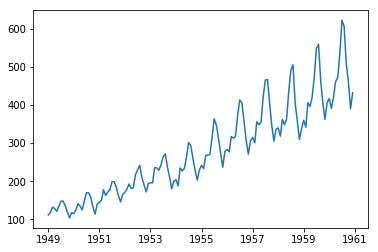

In [2]:
# Visual analysis
plt.plot(ts)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


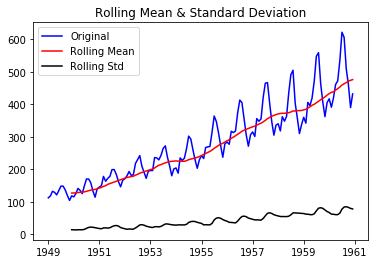

Results of Dickey-Fuller Test: 
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform the Dickey-Fuller test
    print ('Results of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(ts)

    

### Mean is clearly increasing with time, therefore this is not a stationary series.

# Making a Time Series Stationary

It is almost impossible to make a series perfectly stationary, but there is a way to make it as stationary as possible. The underlying principle is to estimate the trend and seasonality in this series and remove those to get a stationary series (we would still need to convert the forecasted values into the original scale by applying trend and seasonality back).

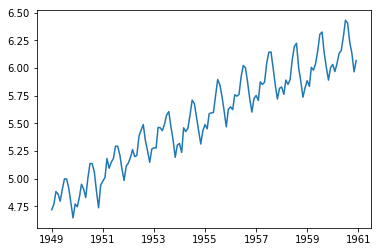

In [4]:
# Transforming the time series into log
ts_log = np.log(ts)
plt.plot(ts_log)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  


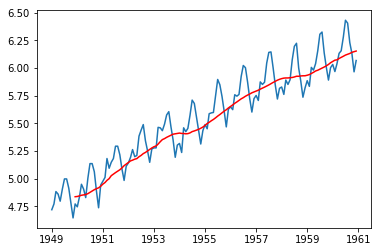

In [5]:
# Creating a moving average
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [6]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


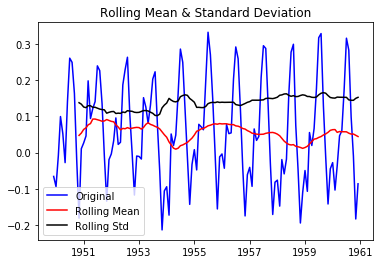

Results of Dickey-Fuller Test: 
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [7]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  """


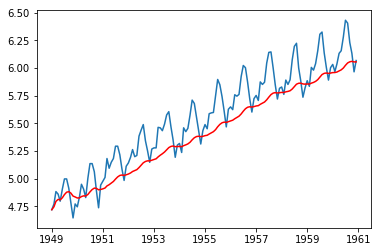

In [8]:
# Exponentially weighted moving average
# The parameter halflife is used to define the amount of exponential decay (an assumption, would depend largely on the business domain)


expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


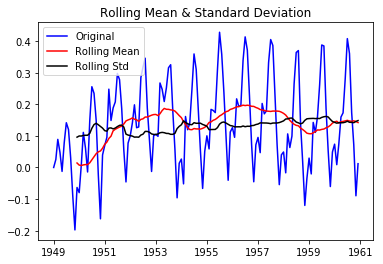

Results of Dickey-Fuller Test: 
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

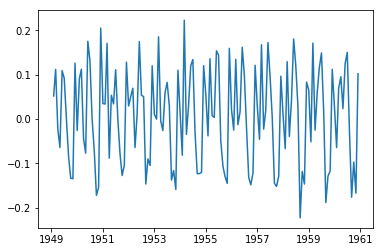

In [10]:
# Differencing to eliminate trend and seasonality
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


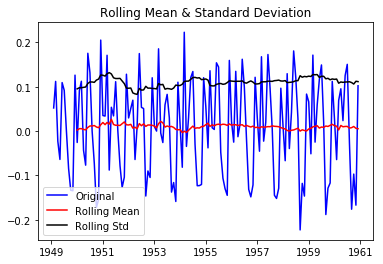

Results of Dickey-Fuller Test: 
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [11]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### The Dickey-Fuller test statistic is less than the 10% critical value, thus the time series is stationary with 90% confidence.

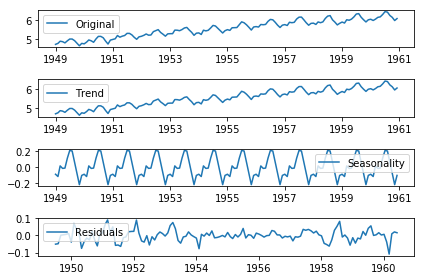

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_log, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


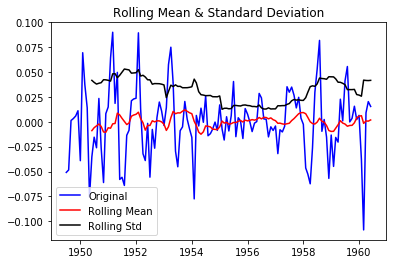

Results of Dickey-Fuller Test: 
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [13]:
#Checking stationarity of residuals
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Stationarity Update

The Dickey-Fuller test statistic (-6.332387e+00) is **significantly lower than the 1% critical value**. Therefore, this time series is very close to stationary.

# Forecasting a Time Series

What method are we going to use for forecasting this time series?

ARIMA: Auto-Regressive Integrated Moving Averages.

The ARIMA model is used to overcome the issue of stationarity in a time series (by creating a new function with a constant mean), the new function being the differences in values of the original time series.


The predictors depend on the parameters (p,q,d).

How to determine the value of p and q? We use two plots:

- Autocorrelation Function (ACF): measure of correlation between the time series with a lagged version of itself
- Partial Autocorrelation Function (PACF): Same as above but is done after eliminating the variations already explained by the intervening comparisons (???)



In [14]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [16]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

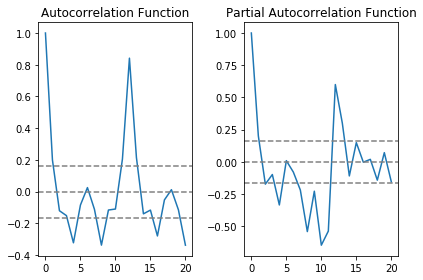

In [19]:
#Plot ACF:

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The two dotted lines on either side of 0 are the confidence intervals.

From the above graphs, we can determine our values for p and q:

- p - The lag value where the PACF chart crosses the upper confidence interval for the first time (in this case p=2)
- q - The lag value where the ACF chart crosses the upper confidence interval for the first time (in this case q=2)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.5023')

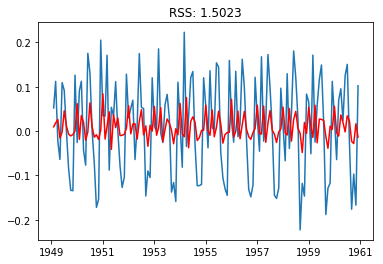

In [22]:
#Loading the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

#AR Model
model = ARIMA(ts_log, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.4721')

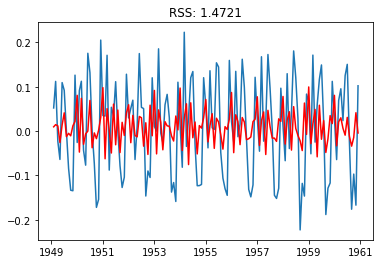

In [23]:
#MA Model
model = ARIMA(ts_log, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.0292')

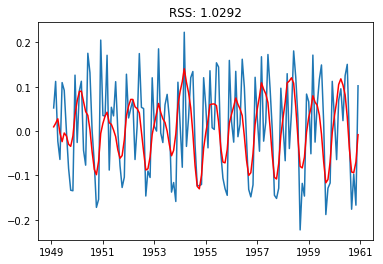

In [24]:
#Combined Model
model = ARIMA(ts_log,order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

# Scaling back to original values



Text(0.5,1,'RMSE: 90.1044')

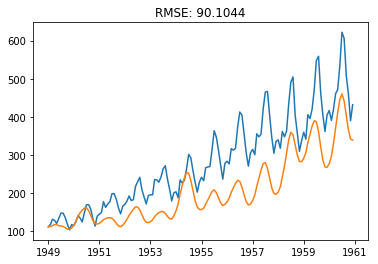

In [31]:
#Storing the predicted results as a separate series
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)


#Actual prediction model lol
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
